In [ ]:
#Demo to show case stable diffusion using determined

## Before You Start: 🤗 Account, Access Token, and License

In order to use this repository's implementation of Stable Diffusion, you must:

* Have a [Huggingface account](https://huggingface.co/join).
* Have a [Huggingface User Access Token](https://huggingface.co/docs/hub/security-tokens).
* Accept the Stable Diffusion license (click on _Access
  repository_  [in this link)](https://huggingface.co/CompVis/stable-diffusion-v1-4).


In [1]:
# libraries for visualization and prompt inference
! pip install -qq jupyterlab-widgets==1.1.1 ipywidgets==7.7.2

In [ ]:
# Set HF Token as environment variable and update const.yaml with it as below
%env HF_AUTH_TOKEN=<HF_AUTH_TOKEN>

## Training Setup

1. After including your user access token in the `const.yaml` config file by modifying the final part
of the lines which read

2. Update the resource pool name based on your cluster, this has been tested on 2 gpu slots of v100

```yaml
environment:
  environment_variables:
    - HF_AUTH_TOKEN=YOUR_HF_AUTH_TOKEN_HERE
resources:
  ...
  resource_pool: v100-gpu-pool #your GPU resource pool, tested against v100
```

## Fine-tuning
Fine-tuning experiment can be run by executing the following in the present directory

The below command will submit an experiment which introduces a new embedding vector into the world of Stable
Diffusion which we will train to correspond to the concept of the Determined AI logo, as represented
through
training images found in `/det_logos`


In [3]:
!det experiment create const.yaml .

52.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Preparing files (/run/determined/workdir) to send to master... 3.5MB and 24 files  
Created experiment 106


By default, sample images are generated during training which can be viewed by launching a
Tensorboard instance from the experiment in the WebUI.

## Prompt Inference

In [4]:
# Once the fine tuning is complete, grab the UUID of best checkpoint from the above experiment. pass the experiment id from above
!det experiment list-checkpoints --best 1 106

846.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   Trial ID |   # of Batches | State     | Validation Metric   | UUID                                 | Resources                  | Size
------------+----------------+-----------+---------------------+--------------------------------------+----------------------------+---------
        686 |            250 | COMPLETED |                     | 1cccbbf2-f0bf-4478-bfd0-ea558fb26588 | learned_embeddings_dict.pt | 289.6MB
            |                |           |                     |                                      | optimizer_state_dict.pt    |


In [5]:
checkpoint_uuids = ['1cccbbf2-f0bf-4478-bfd0-ea558fb26588'] #UUID of your best ckpt from the above run

# Create a textual inversion pipeline for prompt inference
from detsd import DetSDTextualInversionPipeline
detsd_pipeline = DetSDTextualInversionPipeline()

# load ckpts
detsd_pipeline.load_from_uuids(checkpoint_uuids)


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

--------------------------------------------------------------------------------
Building the pipeline...
--------------------------------------------------------------------------------
Done!
Successfully loaded checkpoints. All loaded concepts: ['<det-logo>']


In [6]:
# Create a directory in which to save the generated images:
!mkdir generated_images

1109.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [7]:
# Grab the first concept which was loaded into the pipeline, if any, otherwise falling back to a default:
try:
    first_concept = detsd_pipeline.all_added_concepts[0]
except IndexError:
    first_concept = 'orange brain'
print(f'Using "{first_concept}" as first_concept in the below')
print(f'All available concepts: {detsd_pipeline.all_added_concepts}')

Using "<det-logo>" as first_concept in the below
All available concepts: ['<det-logo>']


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

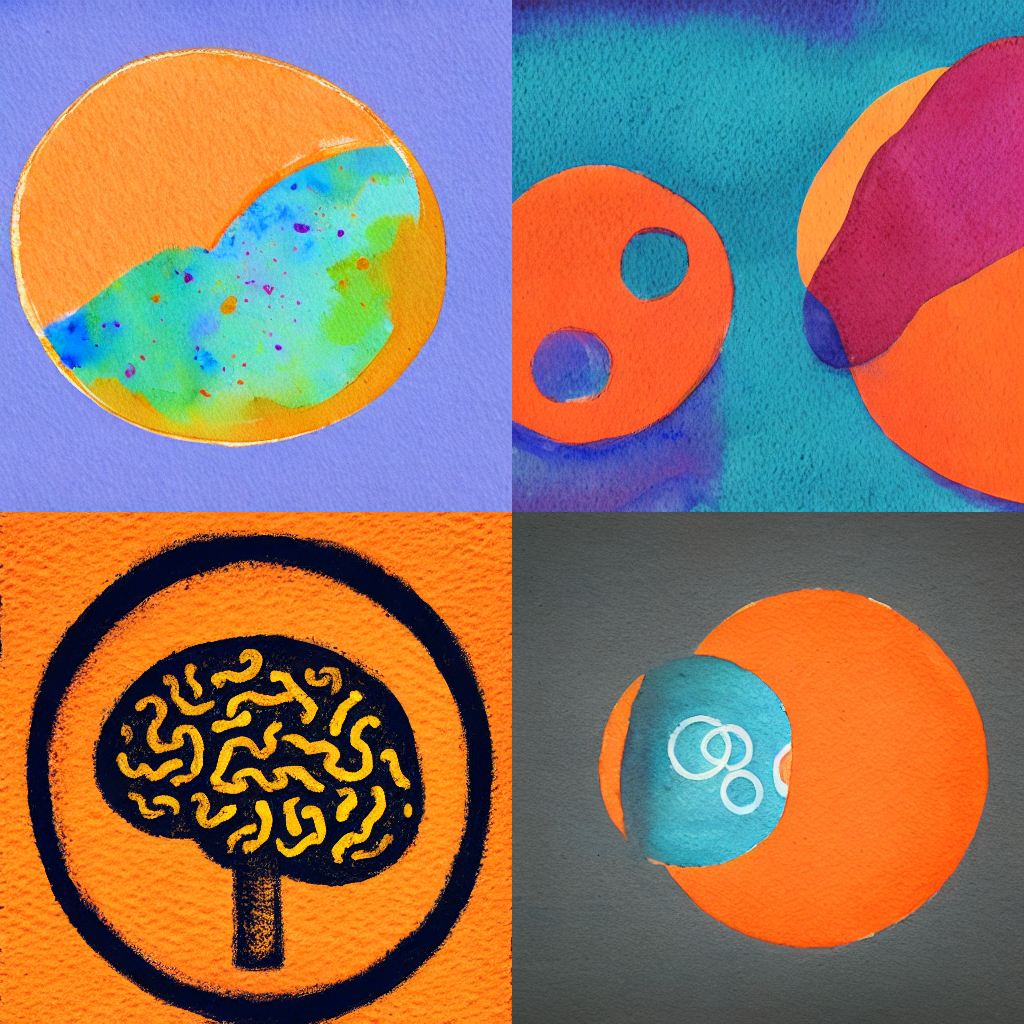

In [8]:
# Generate and inspect images based on prompt. Generating right prompts is an art, good luck
prompt = f"a watercolor painting on textured paper of a {first_concept} using soft strokes, pastel colors, incredible composition, masterpiece"
imgs = detsd_pipeline(prompt=prompt,
                      parallelize_factor=2,
                      rows=2,
                      cols=2,
                      num_inference_steps=50,
                      seed=2147483647,
                      guidance_scale=7.5,
                      saved_img_dir='generated_images')
imgs